## Import Necessary Libraries

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


## Import Data

In [2]:
#define data paths
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

## Create Data Generators with Augmentation

In [3]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [4]:
#test the generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 544 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


## Baseline CNN model

In [ ]:
#define function to create cnn model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [6]:
#create untrained model
cnn_model = create_model()

/Users/gabriellamessenger/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
#model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

In [9]:
#train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks = callbacks)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 717ms/step - accuracy: 0.4549 - loss: 1.3088 - val_accuracy: 0.5613 - val_loss: 1.0487
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 687ms/step - accuracy: 0.5470 - loss: 1.0597 - val_accuracy: 0.6000 - val_loss: 0.9868
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 684ms/step - accuracy: 0.5599 - loss: 0.9767 - val_accuracy: 0.5613 - val_loss: 0.9475
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 711ms/step - accuracy: 0.5764 - loss: 0.9790 - val_accuracy: 0.5677 - val_loss: 0.8896
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.5543 - loss: 0.9852 - val_accuracy: 0.6452 - val_loss: 0.8967
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 681ms/step - accuracy: 0.6059 - loss: 0.9198 - val_accuracy: 0.6710 - val_loss: 0.8665
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 672ms/step - accuracy: 0.5709 - loss: 0.9217 - val_accuracy: 0.6581 - val_loss: 0.8368
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 656ms/step - accuracy: 0.5967 - loss: 0.9075 - val_accu

## Display Training Progress

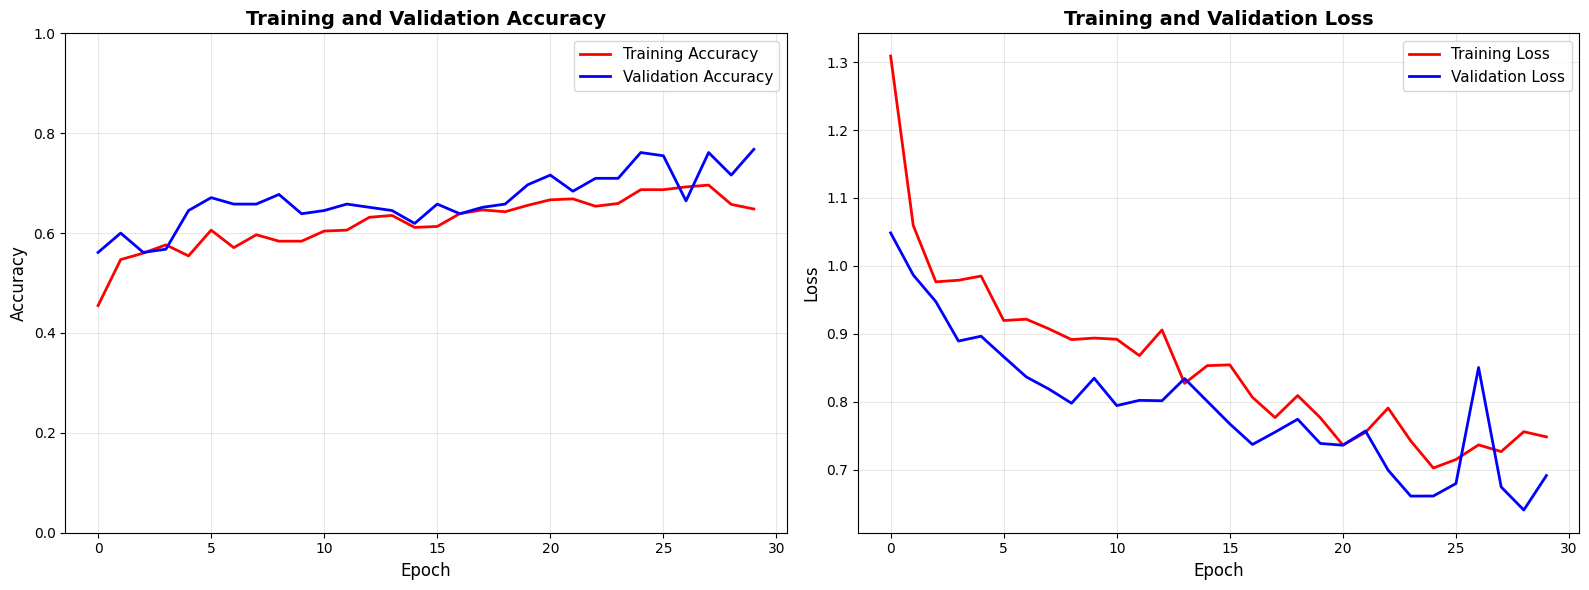


  Training Summary
  Best Training Accuracy:   0.6961 (epoch 28)
  Best Validation Accuracy: 0.7677 (epoch 30)
  Final Training Accuracy:  0.6483
  Final Validation Accuracy:0.7677
  Accuracy Gap (final):     0.1195


In [10]:
#training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs actually executed with early stopping
epochs_range = range(len(acc))

#create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

#plot loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print summary stats
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

## Evaluate model

In [11]:
#get test accuracy and loss
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.7683 - loss: 0.5469
Loss = 0.5469176173210144
Test Accuracy = 0.7682926654815674


In [12]:
#evaluate on val set
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = cnn_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step
Val Classification Report:
              precision    recall  f1-score   support

      benign       0.58      0.75      0.65        87
   malignant       0.29      0.21      0.25        42
      normal       0.36      0.15      0.22        26

    accuracy                           0.50       155
   macro avg       0.41      0.37      0.37       155
weighted avg       0.46      0.50      0.47       155



In [13]:
#evaluate on test set
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.52      0.60      0.56        45
   malignant       0.26      0.27      0.27        22
      normal       0.43      0.20      0.27        15

    accuracy                           0.44        82
   macro avg       0.40      0.36      0.37        82
weighted avg       0.43      0.44      0.43        82



In [14]:
#evaluate on train set
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = cnn_model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Train Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.56      0.63      0.59       305
   malignant       0.24      0.27      0.25       146
      normal       0.29      0.11      0.16        92

    accuracy                           0.44       543
   macro avg       0.36      0.34      0.33       543
weighted avg       0.43      0.44      0.43       543



### Tuning.

- for loop to implement:
    - diff amounts of dropout
    - diff number of layers
    - diff number of filters
    - diff kernel size
    - diff activation functions


In [22]:
cnn_model = create_model(4, 32)

preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.2805 - loss: 1.0980
Loss = 1.0980299711227417
Test Accuracy = 0.2804878056049347


In [18]:
## t1 - add 16 and 256 layers


def create_model():

  model = keras.models.Sequential([

    #keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    #keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [19]:
model = create_model()

#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

/Users/gabriellamessenger/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 718ms/step - accuracy: 0.4871 - loss: 1.4805 - val_accuracy: 0.5613 - val_loss: 1.0740
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 681ms/step - accuracy: 0.5147 - loss: 1.1112 - val_accuracy: 0.5613 - val_loss: 1.0254
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step - accuracy: 0.5515 - loss: 1.0382 - val_accuracy: 0.5613 - val_loss: 0.9870
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 664ms/step - accuracy: 0.5221 - loss: 1.0335 - val_accuracy: 0.5613 - val_loss: 0.9687
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 649ms/step - accuracy: 0.5460 - loss: 1.0324 - val_accuracy: 0.5613 - val_loss: 1.0247
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step - accuracy: 0.5386 - loss: 1.0263 - val_accuracy: 0.5613 - val_loss: 0.9683
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 664ms/step - accuracy: 0.5625 - loss: 0.9943 - val_accuracy: 0.5613 - val_loss: 0.9546
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step - accuracy: 0.5607 - loss: 0.9807 - val_accu

In [20]:
#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7654 - loss: 0.7376
Loss = 0.7376151084899902
Test Accuracy = 0.7654321193695068


In [21]:
## t2 - change dropout to 0.4


def create_model():

  model = keras.models.Sequential([

    #keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    #keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = create_model()

#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 914ms/step - accuracy: 0.4136 - loss: 1.3677 - val_accuracy: 0.2710 - val_loss: 1.0697
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 931ms/step - accuracy: 0.5165 - loss: 1.0844 - val_accuracy: 0.5613 - val_loss: 0.9944
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 680ms/step - accuracy: 0.5570 - loss: 1.0616 - val_accuracy: 0.5613 - val_loss: 0.9781
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step - accuracy: 0.5607 - loss: 1.0095 - val_accuracy: 0.5613 - val_loss: 0.9728
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 648ms/step - accuracy: 0.5570 - loss: 0.9977 - val_accuracy: 0.5613 - val_loss: 1.0593
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 755ms/step - accuracy: 0.5441 - loss: 0.9843 - val_accuracy: 0.5613 - val_loss: 0.9341
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 676ms/step - accuracy: 0.5680 - loss: 0.9872 - val_accuracy: 0.5613 - val_loss: 0.9327
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 657ms/step - accuracy: 0.5515 - loss: 0.9325 - val_accu

In [22]:
## t2 - change dropout to 0.6


def create_model():

  model = keras.models.Sequential([

    #keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    #keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.65),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.65),
    keras.layers.Dense(128, activation="relu"), 
    keras.layers.Dropout(0.65),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = create_model()

#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 725ms/step - accuracy: 0.3787 - loss: 1.7610 - val_accuracy: 0.5613 - val_loss: 1.1491
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 686ms/step - accuracy: 0.4890 - loss: 1.3418 - val_accuracy: 0.5613 - val_loss: 1.1876
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 693ms/step - accuracy: 0.4816 - loss: 1.2022 - val_accuracy: 0.5613 - val_loss: 1.0519
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 674ms/step - accuracy: 0.4798 - loss: 1.1844 - val_accuracy: 0.5613 - val_loss: 1.0141
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 694ms/step - accuracy: 0.5092 - loss: 1.1247 - val_accuracy: 0.5613 - val_loss: 0.9799
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 671ms/step - accuracy: 0.5092 - loss: 1.1324 - val_accuracy: 0.5613 - val_loss: 0.9854
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 684ms/step - accuracy: 0.5515 - loss: 1.0957 - val_accuracy: 0.5613 - val_loss: 1.0057
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.5239 - loss: 1.0806 - val_accu

In [23]:
# back to 2 dense layers


def create_model():

  model = keras.models.Sequential([

    #keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    #keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    #keras.layers.Dense(512, activation="relu"), 
    #keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = create_model()

#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.4761 - loss: 1.2698 - val_accuracy: 0.5613 - val_loss: 0.9996
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step - accuracy: 0.5404 - loss: 1.0564 - val_accuracy: 0.5613 - val_loss: 0.9810
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - accuracy: 0.5551 - loss: 1.0317 - val_accuracy: 0.5613 - val_loss: 0.9704
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 698ms/step - accuracy: 0.5441 - loss: 1.0118 - val_accuracy: 0.5613 - val_loss: 0.9495
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 676ms/step - accuracy: 0.5294 - loss: 0.9765 - val_accuracy: 0.5613 - val_loss: 1.0063
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 660ms/step - accuracy: 0.5754 - loss: 0.9465 - val_accuracy: 0.6000 - val_loss: 0.9132
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 663ms/step - accuracy: 0.5662 - loss: 0.9583 - val_accuracy: 0.6258 - val_loss: 0.8763
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 661ms/step - accuracy: 0.5938 - loss: 0.8876 - val_accu

In [ ]:
## t2 - change dropout to 0.4


def create_model():

  model = keras.models.Sequential([

    #keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    #keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),

    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"), 
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = create_model()

#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

#train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = callbacks)

#get test accuracy and loss
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))